# Longitudinal ROA Propagation time analysis

In this experiment, we look for all RPKI-Invalid prefixes for a specific day (May 5) in 2018, 2019, 2020, 2021 and 2022. We used the RIB dump from `RRC14` to get the list of *all advertised* prefixes on May 5, for the above mentioned years.

For each of the invalid prefixes, we look for "W" withdrawal messages within 1h from the Not_Before time of the ROA. 

For this experiment, we have used `RRC00` an `RRC14` as source of BGP updates.

* t1 = NotBefore time of ROA which invalidates the announcement
* t2 = Withdrawal time of the announcement
* delta = t2 - t1 (Propagation time)


In [1]:
# import the required library 
import numpy as np 
import glob
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import datetime as dt
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import matplotlib.ticker as ticker
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

rirs = ['afrinic','apnic', 'arin', 'lacnic', 'ripencc']
colors=['tab:orange','tab:blue','tab:cyan','tab:red','tab:green']


def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    boxprops = dict(linewidth=2)
    return df[meds.index].boxplot(rot=rot, return_type="axes", figsize=(20,10), boxprops=boxprops)

## Difference between Signing Time and Not Before time
In this experiment, we use `NotBefore` time as `t1` instead of the `Signing Time` found in the ROA CMS wrapper. This is justified by the fact that the majority of ROA have NotBefore = SigningTime as shown below.

In [2]:
df_roa = pd.read_csv('data/results/roaTime.csv', names=['signing_time','not_before','ta'], parse_dates=True)
df_roa['delta'] = df_roa.apply(lambda x:  (datetime.strptime(x['signing_time'], "%Y-%m-%dT%H:%M:%SZ") - datetime.strptime(x['not_before'], "%b %d %H:%M:%S %Y GMT")).total_seconds() / 60 , axis=1)

df_arin = df_roa.loc[df_roa.ta=='rpki.arin.net']
df_apnic = df_roa.loc[df_roa.ta=='rpki.apnic.net']
df_ripe = df_roa.loc[df_roa.ta=='rpki.ripe.net']
df_lacnic = df_roa.loc[df_roa.ta=='repository.lacnic.net']
df_afrinic = df_roa.loc[df_roa.ta=='rpki.afrinic.net']
df_all = pd.concat([df_arin, df_apnic, df_ripe, df_lacnic, df_afrinic ], ignore_index=False)
df_all_p = df_all.pivot(columns='ta', values='delta')



In [4]:
len(df_afrinic.loc[df_afrinic.delta < 0])/len(df_afrinic)

0.09010930418555052

CDF of difference between Signing Time and NotBefore time in all ROAs found in the RPKI repository for hosted CAs only

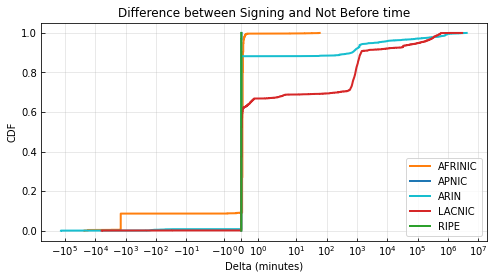

In [214]:
n_bins = 5000

fig, ax1 = plt.subplots(figsize=(8,4))

labels = ['rpki.afrinic.net','rpki.apnic.net', 'rpki.arin.net', 'repository.lacnic.net', 'rpki.ripe.net']
colors=['tab:orange','tab:blue','tab:cyan','tab:red','tab:green']

i=0
for rir in labels:
    X = df_roa.loc[df_roa.ta==rir].delta
    n = np.arange(1,len(X)+1) / np.float(len(X))
    Xs = np.sort(X)
    ax1.step(Xs,n, color=colors[i], label=labels[i].split('.')[1].upper(), linewidth=2)
    i=i+1

                                    
# tidy up the figure
#ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_title('Difference between Signing and Not Before time')
ax1.set_xlabel('Delta (minutes)')
ax1.set_ylabel('CDF')
ax1.set_xscale('symlog')
ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
plt.grid(visible=True, which='major', alpha=0.35, linestyle='-')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.25)
plt.savefig("plots/roa-time-analysis.pdf", bbox_inches='tight')
plt.show()

In [239]:
len(df_lacnic.loc[df_lacnic.delta > 0])/len(df_lacnic)

0.6259497369959088

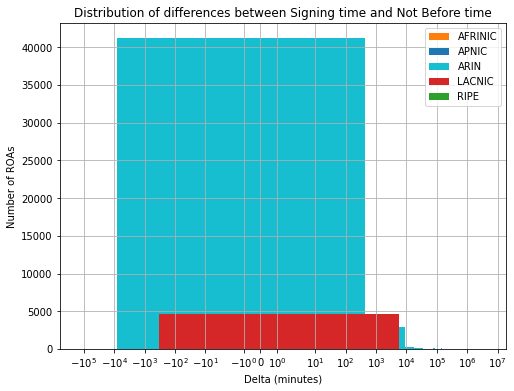

In [233]:
fig, ax1 = plt.subplots(figsize=(8, 6))

labels = ['AFRINIC','APNIC', 'ARIN', 'LACNIC', 'RIPE']
colors=['tab:orange','tab:blue','tab:cyan','tab:red','tab:green']

ax1.hist(x=df_afrinic['delta'].values, bins=500, label='AFRINIC', color='tab:orange')
ax1.hist(x=df_apnic['delta'].values, bins=500, label='APNIC',color='tab:blue')
ax1.hist(x=df_arin['delta'].values, bins=500, label='ARIN',color='tab:cyan')
ax1.hist(x=df_lacnic['delta'].values, bins=500, label='LACNIC',color='tab:red')
ax1.hist(x=df_ripe['delta'].values, bins=500, label='RIPE',color='tab:green')
ax1.grid(True)
ax1.set_title('Distribution of differences between Signing time and Not Before time')
ax1.set_xlabel('Delta (minutes)')
ax1.set_ylabel('Number of ROAs')
ax1.set_xscale('log')
ax1.legend()

Same data in a histogram

Text(0, 0.5, 'Number of ROAs')

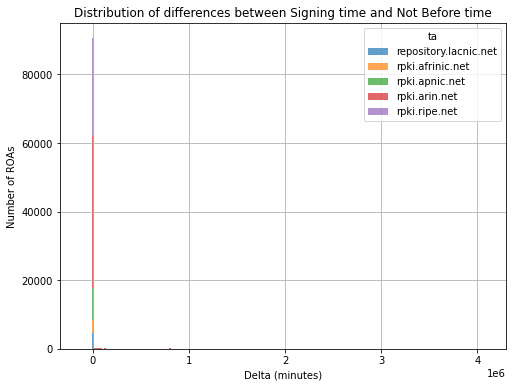

In [36]:
fig, ax1 = plt.subplots(figsize=(8, 6))

labels = ['AFRINIC','APNIC', 'ARIN', 'LACNIC', 'RIPE']
colors=['orange','blue','cyan','red','green']

df_all_p.plot.hist(ax = ax1, bins=200, figsize=(8,6), alpha=0.7, stacked=True)
ax1.grid(True)
ax1.set_title('Distribution of differences between Signing time and Not Before time')
ax1.set_xlabel('Delta (minutes)')
ax1.set_ylabel('Number of ROAs')

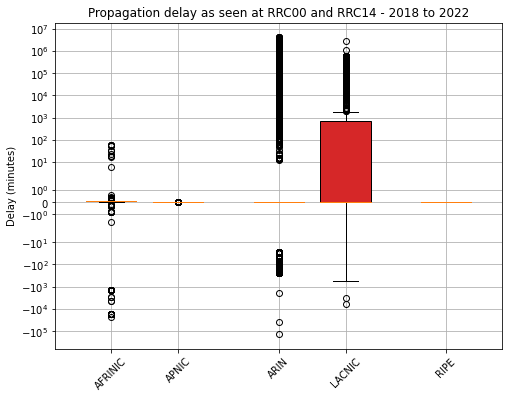

In [92]:
fig, ax1 = plt.subplots(figsize=(8, 6))

data = []

labels = ['rpki.afrinic.net','rpki.apnic.net', 'rpki.arin.net', 'repository.lacnic.net', 'rpki.ripe.net']
colors=['tab:orange','tab:blue','tab:cyan','tab:red','tab:green']

i=0
for rir in labels:
    data.append(df_roa.loc[df_roa.ta==rir].delta)

box = ax1.boxplot(data, positions=[1, 1.6, 2.5, 3.1, 4], patch_artist=True,
                  labels=['AFRINIC','APNIC','ARIN','LACNIC', 'RIPE'])

#ax1.set_ylim(0,75)
plt.xticks(rotation=45)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# tidy up the figure
ax1.grid(True)
ax1.set_title('Propagation delay as seen at RRC00 and RRC14 - 2018 to 2022')
ax1.set_ylabel('Delay (minutes)')
ax1.set_yscale('symlog')

plt.show()


The above confirms that, except in a few cases, the majority of ROAs have SigningTime = NotBefore time. The exceptional cases are ROAs from ARIN

## ROA propagation time (RRC00 + RRC14)

In [5]:
df_v4 = pd.concat(map(pd.read_csv, glob.glob("data/results/rrc00/*_v4.csv")))
df_v6 = pd.concat(map(pd.read_csv, glob.glob("data/results/rrc00/*_v6.csv")))

df_v4['delta_min'] = df_v4.delta/60
df_v6['delta_min'] = df_v6.delta/60

df_v4['roa_create_time'] = pd.to_datetime(df_v4['roa_create_time'], format='%Y-%m-%d %H:%M:%S')
df_v6['roa_create_time'] = pd.to_datetime(df_v6['roa_create_time'], format='%Y-%m-%d %H:%M:%S')
df_v4['withdrawal_time'] = pd.to_datetime(df_v4['withdrawal_time'], format='%Y-%m-%d %H:%M:%S')
df_v6['withdrawal_time'] = pd.to_datetime(df_v6['withdrawal_time'], format='%Y-%m-%d %H:%M:%S')

df_v4.drop_duplicates(inplace=True)
df_v6.drop_duplicates(inplace=True)

In [13]:
len(df_v6)

7042

In [6]:
def getDataByRIR(df_v4, df_v6, rir):
    df_4 = df_v4.loc[df_v4.tal==rir]
    df_6 = df_v6.loc[df_v6.tal==rir]
    return df_4, df_6

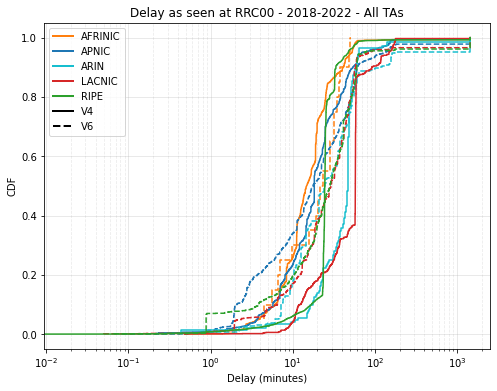

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 6))

i=0
for rir in rirs:
  
    df_4, df_6 = getDataByRIR(df_v4, df_v6, rir)
    #plot the cumulative histogram

    X_4 = df_4['delta_min'].values
    X_6 = df_6['delta_min'].values
    n_4 = np.arange(1,len(X_4)+1) / np.float(len(X_4))
    n_6 = np.arange(1,len(X_6)+1) / np.float(len(X_6))
    Xs_4 = np.sort(X_4)
    Xs_6 = np.sort(X_6)
    ax1.step(Xs_4,n_4, color=colors[i])
    ax1.step(Xs_6,n_6, color=colors[i], linestyle='--')  

    i=i+1

orange_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:orange', label='AFRINIC')
blue_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:blue', label='APNIC')
cyan_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:cyan', label='ARIN')
red_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:red', label='LACNIC')
green_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:green', label='RIPE')
v6_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='V6')
v4_line = mlines.Line2D([], [], markersize=15,linewidth=2, color='black', label='V4')
    
plt.legend(handles=[orange_patch, blue_patch, cyan_patch, red_patch, green_patch, v4_line, v6_line], loc="upper left")

# tidy up the figure
ax1.grid(True)
#ax1.legend(loc='lower right')
ax1.set_title('Delay as seen at RRC00 - 2018-2022 - All TAs')
ax1.set_xlabel('Delay (minutes)')
ax1.set_ylabel('CDF')
ax1.set_xscale('log')
plt.grid(visible=True, which='major', alpha=0.35)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.25)
plt.savefig("plots/CDF_2018-2022.pdf")
plt.show()

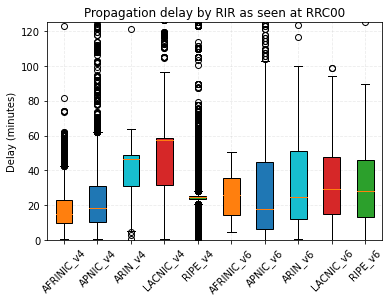

In [8]:
fig, ax1 = plt.subplots()

data4 = []
data6 = []

colors=['tab:orange','tab:blue','tab:cyan','tab:red','tab:green','tab:orange','tab:blue','tab:cyan','tab:red','tab:green']

for rir in rirs:
    df_4, df_6 = getDataByRIR(df_v4, df_v6, rir)
    data4.append(df_4['delta_min'])
    data6.append(df_6['delta_min'])

# box = ax1.boxplot(data4, positions=[1, 1.6, 2.5, 3.1, 4], patch_artist=True,
#                    labels=['AFRINIC_v4','APNIC_v4','ARIN_v4','LACNIC_v4', 'RIPE_v4'])

# box = ax1.boxplot(data6, positions=[4.6, 5.5, 6.1, 7, 7.6], patch_artist=True,
#                    labels=['AFRINIC_v6','APNIC_v6','ARIN_v6','LACNIC_v6','RIPE_v6'])

box = ax1.boxplot(data4 + data6, positions=[1, 2, 3, 4, 5, 6,7, 8, 9, 10], patch_artist=True,
                   labels=['AFRINIC_v4','APNIC_v4','ARIN_v4','LACNIC_v4', 'RIPE_v4','AFRINIC_v6','APNIC_v6','ARIN_v6','LACNIC_v6','RIPE_v6'])

ax1.set_ylim(0,125)
plt.xticks(rotation=45)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# tidy up the figure
plt.grid(visible=True, which='both', alpha=0.35)
plt.grid(visible=True, which='both', linestyle='--', alpha=0.25)
ax1.set_title('Propagation delay by RIR as seen at RRC00')
ax1.set_ylabel('Delay (minutes)')

plt.savefig("plots/boxplot2018-2022.pdf", bbox_inches='tight')
plt.show()

                                 

Now we look at it from a yearly perspective.

In [9]:
def getDatabyYear(df_v4, df_v6, year): 
    df_4 = df_v4.loc[df_v4.roa_create_time.dt.year == year]
    df_6 = df_v6.loc[df_v6.roa_create_time.dt.year == year]

    return df_4, df_6

No handles with labels found to put in legend.


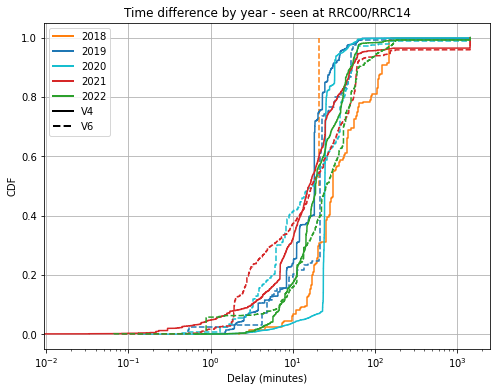

In [10]:
n_bins = 10000

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig, ax1 = plt.subplots(figsize=(8, 6))

data = {}
i=0
for year in range(2018, 2023):
  
    df_4, df_6 = getDatabyYear(df_v4, df_v6, year)

    df_4 = df_4.loc[(df_4.tal != 'lacnic') & (df_4.tal != 'arin') ]
    df_6 = df_6.loc[(df_6.tal != 'lacnic') & (df_6.tal != 'arin') ]
    X_4 = df_4['delta_min'].values
    X_6 = df_6['delta_min'].values
    n_4 = np.arange(1,len(X_4)+1) / np.float(len(X_4))
    n_6 = np.arange(1,len(X_6)+1) / np.float(len(X_6))
    Xs_4 = np.sort(X_4)
    Xs_6 = np.sort(X_6)
    ax1.step(Xs_4,n_4, color=colors[i])
    ax1.step(Xs_6,n_6, color=colors[i], linestyle='--')  

    i=i+1
                                    
# tidy up the figure
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_title('Time difference by year - seen at RRC00/RRC14')
ax1.set_xlabel('Delay (minutes)')
ax1.set_ylabel('CDF')
ax1.set_xscale('log')


orange_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:orange', label='2018')
blue_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:blue', label='2019')
cyan_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:cyan', label='2020')
red_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:red', label='2021')
green_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:green', label='2022')
v6_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='V6')
v4_line = mlines.Line2D([], [], color='black', markersize=15,linewidth=2,  label='V4')

plt.legend(handles=[orange_patch, blue_patch, cyan_patch, red_patch, green_patch, v4_line, v6_line], loc="upper left")

plt.show()

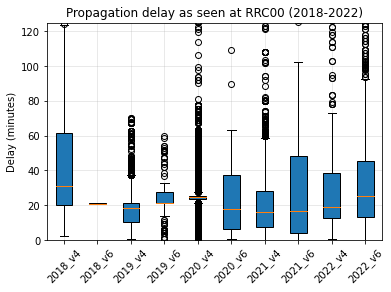

In [11]:
fig, ax1 = plt.subplots()

data = []
for year in range(2018, 2023):
  
    df_4, df_6 = getDatabyYear(df_v4, df_v6, year)
    df_4 = df_4.loc[(df_4.tal != 'lacnic') & (df_4.tal != 'arin') ]
    df_6 = df_6.loc[(df_6.tal != 'lacnic') & (df_6.tal != 'arin') ]
    data.append(df_4['delta_min'])
    data.append(df_6['delta_min'])

box = ax1.boxplot(data, positions=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], patch_artist=True,
                  labels=['2018_v4','2018_v6','2019_v4','2019_v6','2020_v4','2020_v6','2021_v4','2021_v6', '2022_v4','2022_v6'])

ax1.set_ylim(0,125)
plt.xticks(rotation=45)

# for patch, color in zip(box['boxes'], colors):
#     patch.set_facecolor(color)

# tidy up the figure
ax1.grid(True)
ax1.set_title('Propagation delay as seen at RRC00 (2018-2022)')
ax1.set_ylabel('Delay (minutes)')

plt.grid(visible=True, which='major', alpha=0.35)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.25)

plt.savefig("plots/boxplot-by-year-2018-2022.pdf", bbox_inches='tight')
plt.show()

                                 

In [247]:
df_v4.head()

,prefix,tal,peer_ip,roa_create_time,withdrawal_time,delta,delta_min
0,37.205.112.0/24,ripencc,176.12.110.8,2018-01-01 00:59:44,2018-01-01 02:00:53,3669,61.150000
1,37.205.112.0/24,ripencc,12.0.1.63,2018-01-01 00:59:44,2018-01-01 02:01:05,3681,61.350000
2,37.205.112.0/24,ripencc,12.0.1.63,2018-01-01 00:59:44,2018-01-01 02:01:34,3710,61.833333
3,37.205.112.0/24,ripencc,176.12.110.8,2018-01-01 00:59:44,2018-01-01 02:01:43,3719,61.983333
4,37.205.112.0/24,ripencc,213.200.87.254,2018-01-01 00:59:44,2018-01-01 02:01:45,3721,62.016667


## Propagation time as seen at RRC00 by year


In [194]:
def getDataByYearRIR(df_v4, df_v6, year, rir):
    df_4 = df_v4.loc[ ((df_v4.tal==rir) & (df_v4.roa_create_time.dt.year == year))]
    df_6 = df_v6.loc[ ((df_v6.tal==rir) & (df_v6.roa_create_time.dt.year == year))]

    return df_4, df_6


def plotByYear(df_v4, df_v6, year):
    n_bins = 5000

    fig, ax1 = plt.subplots(figsize=(8, 6))
    
    i=0
    for rir in rirs:
        df_4, df_6 = getDataByYearRIR(df_v4, df_v6, year, rir)

        X_4 = df_4['delta_min'].values
        X_6 = df_6['delta_min'].values
        n_4 = np.arange(1,len(X_4)+1) / np.float(len(X_4))
        n_6 = np.arange(1,len(X_6)+1) / np.float(len(X_6))
        Xs_4 = np.sort(X_4)
        Xs_6 = np.sort(X_6)
        ax1.step(Xs_4,n_4, color=colors[i])
        ax1.step(Xs_6,n_6, color=colors[i], linestyle='--')  

        i=i+1
    
    orange_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:orange', label='AFRINIC')
    blue_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:blue', label='APNIC')
    cyan_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:cyan', label='ARIN')
    red_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:red', label='LACNIC')
    green_patch = mlines.Line2D([], [], markersize=15,linewidth=2,color='tab:green', label='RIPE')
    v6_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='V6')
    v4_line = mlines.Line2D([], [], markersize=15,linewidth=2, color='black', label='V4')
    
    plt.legend(handles=[orange_patch, blue_patch, cyan_patch, red_patch, green_patch, v4_line, v6_line], loc="upper left")
    
    # tidy up the figure
    ax1.grid(True)
    #ax1.legend(loc='lower right')
    ax1.set_title(f'Propagation time - seen at RRC00 in {str(year)}')
    ax1.set_xlabel('Delay (minutes)')
    ax1.set_ylabel('CDF')
    ax1.set_xscale('log')
    
    plt.grid(visible=True, which='major', alpha=0.35, linestyle='--')
    plt.grid(visible=True, which='minor', linestyle='--', alpha=0.25)
    plt.savefig(f'plots/CDF_rrc00-{str(year)}.pdf')
    plt.show()

## Plots - Propagation time

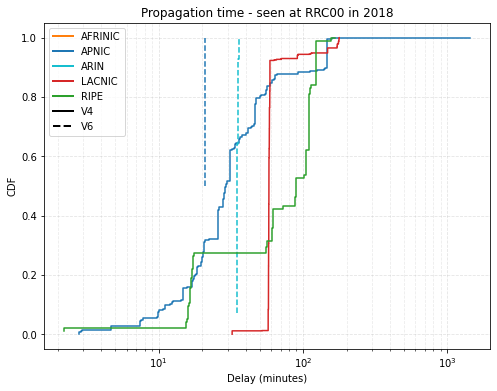

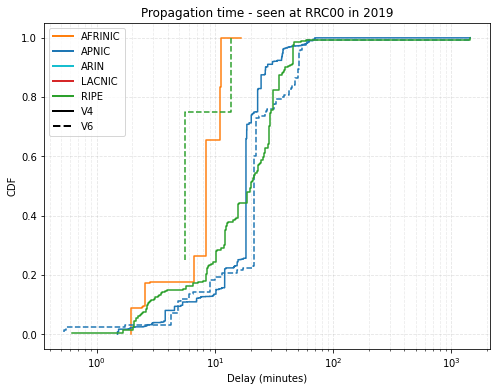

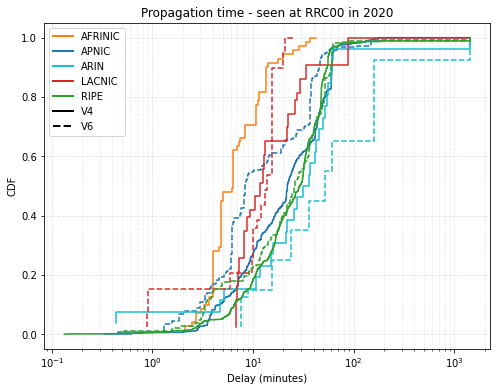

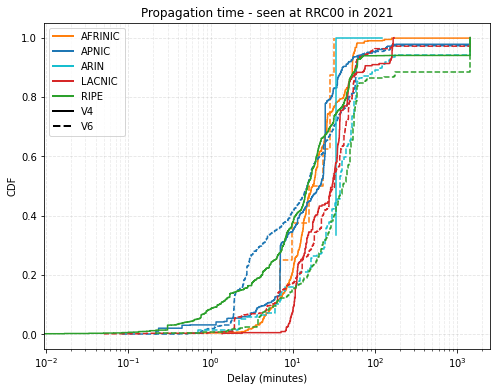

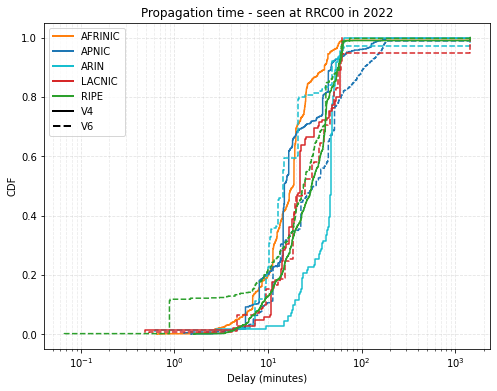

In [195]:
for year in range(2018, 2023):
    plotByYear(df_v4, df_v6, year)

## Same information in box plots

In [196]:
def boxplotbyYear(df_v4, df_v6, year):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    colors=['tab:orange','tab:orange', 'tab:blue', 'tab:blue', 'tab:cyan','tab:cyan','tab:red','tab:red','tab:green','tab:green']

    data = []
    for rir in rirs:
        df_4, df_6 = getDataByYearRIR(df_v4, df_v6, year, rir)
        data.append(df_4['delta_min'])
        data.append(df_6['delta_min'])

    box = ax1.boxplot(data, positions=[1, 1.6, 2.5, 3.1, 4, 4.6, 5.5, 6.1, 7, 7.6], patch_artist=True,
                    labels=['AFRINIC_v4','AFRINIC_v6','APNIC_v4','APNIC_v6','ARIN_v4','ARIN_v6','LACNIC_v4','LACNIC_v6', 'RIPE_v4','RIPE_v6'])
    ax1.set_ylim(0,200)
    plt.xticks(rotation=45)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # tidy up the figure
    ax1.grid(True)
    ax1.set_title(f'Propagation delay as seen at RRC00 in {year}')
    ax1.set_ylabel('Delay (minutes)')

    plt.show()


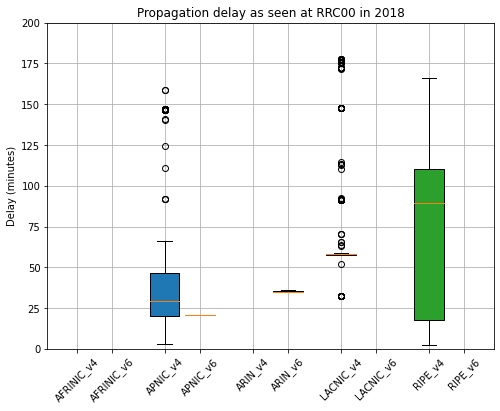

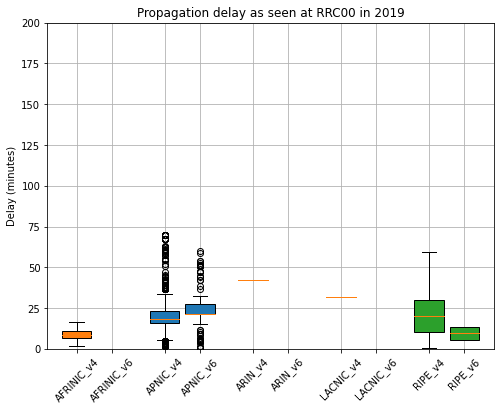

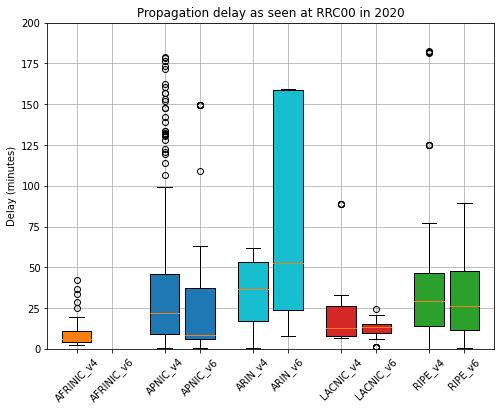

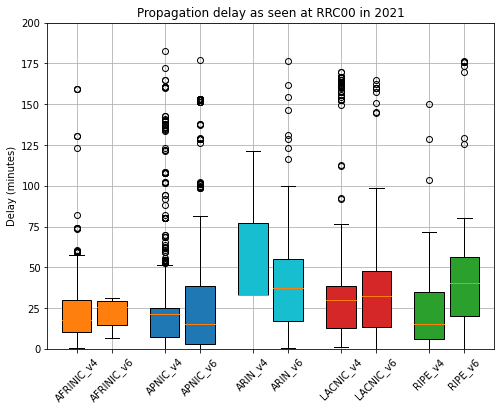

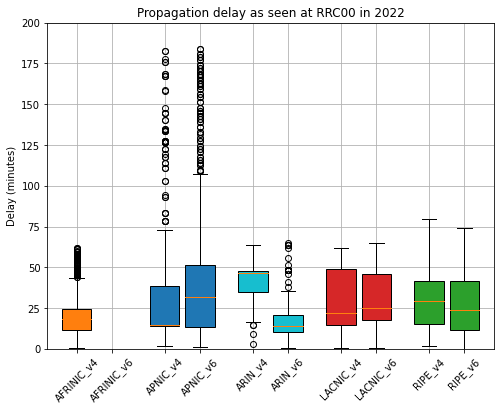

In [197]:
for year in range(2018, 2023):
    boxplotbyYear(df_v4, df_v6, year)

In the above, ARIN is not appearing since we are using a time span of 1 hour. Most of updates for ARIN > 60 mins.

In [223]:
df_median = pd.DataFrame(columns=['year','rir','median_delay'])

for rir in rirs:
    for year in range(2016, 2023):
        df_4, df_6 = getDataByYearRIR(df_v4, df_v6, year, rir)
        median_4 = np.median(df_4['delta_min'].values, axis=0)
        median_6 = np.median(df_6['delta_min'].values, axis=0)

        df_median = df_median.append({'year':year, 'rir':rir.upper() + '_v4', 'median_delay':median_4 }, ignore_index = True)
        df_median = df_median.append({'year':year, 'rir':rir.upper() + '_v6', 'median_delay':median_6 }, ignore_index = True)

In [224]:
df_matrix = df_median.pivot("rir", "year", "median_delay")
df_matrix

year,2016,2017,2018,2019,2020,2021,2022
rir,,,,,,,
AFRINIC_v4,NaN,NaN,NaN,8.400000,6.316667,17.550000,18.566667
AFRINIC_v6,NaN,NaN,NaN,NaN,NaN,25.775000,NaN
APNIC_v4,NaN,109.300000,29.175000,18.300000,22.091667,21.500000,14.900000
APNIC_v6,NaN,NaN,20.941667,21.300000,8.450000,14.983333,31.783333
ARIN_v4,NaN,NaN,NaN,42.216667,36.700000,33.266667,46.700000
ARIN_v6,NaN,NaN,34.850000,NaN,52.433333,37.500000,14.308333
LACNIC_v4,51.058333,117.883333,58.000000,31.566667,12.683333,30.233333,21.883333
LACNIC_v6,NaN,NaN,NaN,NaN,13.716667,32.266667,24.783333
RIPENCC_v4,NaN,NaN,89.500000,20.066667,24.550000,15.366667,29.283333


Text(0, 0.5, 'RIR')

<Figure size 432x288 with 0 Axes>

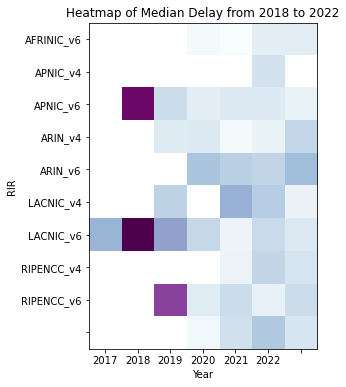

In [200]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, figsize=(6,6))
heatplot = ax.imshow(df_matrix, cmap='BuPu')
ax.set_xticklabels(df_matrix.columns)
ax.set_yticklabels(df_matrix.index)

tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_title("Heatmap of Median Delay from 2018 to 2022")
ax.set_xlabel('Year')
ax.set_ylabel('RIR')

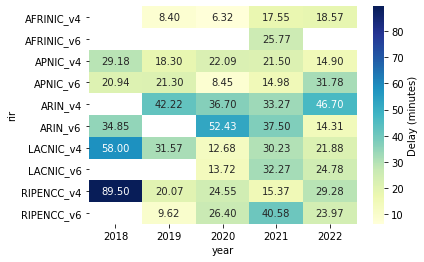

In [225]:
import seaborn as sns;

ax = sns.heatmap(df_matrix.iloc[:,[2,3,4,5,6]], annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Delay (minutes)'})
fig = ax.get_figure()
fig.savefig("plots/matrix_delay.pdf",bbox_inches='tight') 